# Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob, os, random

# Load the Dataset

In [2]:
path = '/content/drive/MyDrive/Dataset/Garbage classification'
img = glob.glob(os.path.join(path, '*/*.jpg'))

print(len(img))

3131


# Load Pre-trained model - Transfer Learning

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Tuning the model

In [4]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=True)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='training',
    seed=0
)

val_generator = test_datagen.flow_from_directory(
    path,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)
print(len(labels))

Found 3139 images belonging to 8 classes.
Found 312 images belonging to 8 classes.
{0: 'B3', 1: 'cardboard', 2: 'glass', 3: 'metal', 4: 'organic', 5: 'paper', 6: 'plastic', 7: 'trash'}
8


# Building the Model

In [14]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 2587976 (9.87 MB)
Trainable params: 2553864 (9.74 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [26]:
history = model.fit(train_generator, epochs=50,
                    steps_per_epoch=25,
                    validation_data=val_generator)

model.save('model_new_v2.h5')

Epoch 1/50
25/25 [==============================] - 15s 596ms/step - loss: 0.4913 - accuracy: 0.9824 - val_loss: 0.5588 - val_accuracy: 0.9647
Epoch 2/50
25/25 [==============================] - 13s 507ms/step - loss: 0.5055 - accuracy: 0.9824 - val_loss: 0.4901 - val_accuracy: 0.9872
Epoch 3/50
25/25 [==============================] - 12s 493ms/step - loss: 0.5170 - accuracy: 0.9712 - val_loss: 0.4857 - val_accuracy: 0.9872
Epoch 4/50
25/25 [==============================] - 15s 604ms/step - loss: 0.4983 - accuracy: 0.9760 - val_loss: 0.4703 - val_accuracy: 0.9872
Epoch 5/50
25/25 [==============================] - 12s 497ms/step - loss: 0.5108 - accuracy: 0.9696 - val_loss: 0.4513 - val_accuracy: 0.9936
Epoch 6/50
25/25 [==============================] - 13s 526ms/step - loss: 0.4943 - accuracy: 0.9744 - val_loss: 0.4842 - val_accuracy: 0.9872
Epoch 7/50
25/25 [==============================] - 14s 544ms/step - loss: 0.4761 - accuracy: 0.9856 - val_loss: 0.4591 - val_accuracy: 0.9904

# Graph

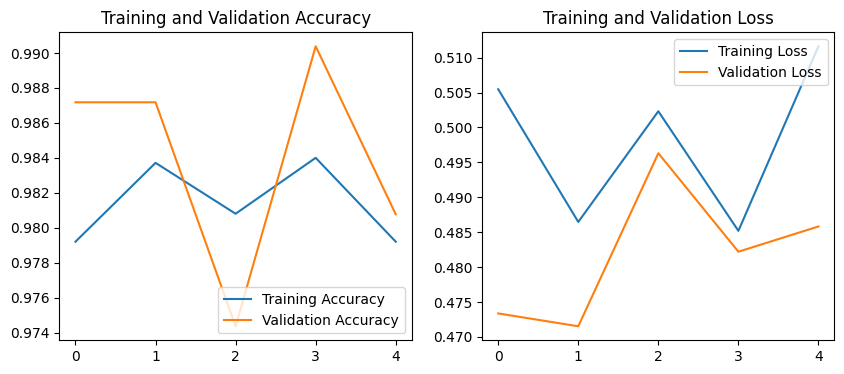

In [25]:
acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range   = range(len(acc))
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
eval = model.evaluate(train_generator, return_dict=True, verbose=0)

print(eval)

{'loss': 0.5206363201141357, 'accuracy': 0.9812042117118835}
